In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset 
import torch.nn.functional as F
import tqdm

In [243]:
# SCALER = 'NONE'
SCALER = 'MINMAX'
# LAST_N = -15
TRAIN_TEST_SPLIT = 0.95

In [244]:
df = pd.read_csv('total.csv')
df.head()

,Date,S&P,currency,gold,kospi,kospi_shift
0,2003-12-01,1070.119995,1198.400024,402.700012,807.390015,807.780029
1,2003-12-02,1066.619995,1195.000000,403.700012,807.780029,808.340027
2,2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005
3,2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
4,2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988


In [245]:
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5328,2024-05-02,5064.200195,1375.000000,2299.199951,2683.649902,2676.629883
5329,2024-05-03,5127.790039,1364.640015,2299.000000,2676.629883,2734.360107
5330,2024-05-06,5180.740234,1355.050049,2321.600098,2676.629883,2734.360107
5331,2024-05-07,5187.700195,1352.170044,2316.300049,2734.360107,2737.669922
5332,2024-05-08,5187.700195,1352.170044,2316.300049,2737.669922,2737.669922


In [246]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :].drop('Date', axis=1)
# df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :].drop('Date', axis=1)
# train_x, test_x, train_y, test_y = train_test_split(df_1.loc[:, 'S&P':'kospi'], df_1.loc[:, 'kospi_shift'], train_size=0.9)
col_names = df_train.columns.values
print(col_names)

['Date' 'S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [247]:
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[1:]:
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

,S&P,currency,gold,kospi,kospi_shift
mean,2.056123e+03,1120.055541,1210.548914,1906.951823,1907.185882
var,1.033928e+06,11114.913679,196573.860870,285002.080969,284980.101274
max,4.796560e+03,1571.400024,2051.500000,3305.209961,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027,719.590027


In [248]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
elif SCALER == 'NONE':
    for i in col_names[1:]:
        train_data[i] = df_train[i]
        test_data[i] = df_test[i]

test_data.tail()

,S&P,currency,gold,kospi,kospi_shift
5328,1.064961,0.713167,1.147731,0.759609,0.756894
5329,1.080395,0.698037,1.147611,0.756894,0.779221
5330,1.093247,0.684031,1.161090,0.756894,0.779221
5331,1.094936,0.679825,1.157929,0.779221,0.780501
5332,1.094936,0.679825,1.157929,0.780501,0.780501


In [249]:
len(df_test)

267

In [250]:
class StockDataset(Dataset):
    def __init__(self, y, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        print(y.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[:,i] = y[end_x: end_x + output_window]
        # print(X.shape, Y.shape)
        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        print(X.shape, Y.shape)
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [251]:
BATCH_SIZE = 64
train_dataset = StockDataset(train_data['kospi'], 128, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data['kospi'], 128, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(next(iter(test_dataset)))

(5066,) 4938 4938 0 5066
(4938, 128, 1) (4938, 1, 1)
(267,) 139 139 0 267
(139, 128, 1) (139, 1, 1)
(array([[0.69801437],
       [0.68912289],
       [0.688945  ],
       [0.688945  ],
       [0.69369048],
       [0.69247224],
       [0.6872317 ],
       [0.68510068],
       [0.67907501],
       [0.68059503],
       [0.6809392 ],
       [0.68651617],
       [0.69453745],
       [0.70319693],
       [0.71065744],
       [0.71470675],
       [0.71466804],
       [0.70973305],
       [0.71132652],
       [0.71132652],
       [0.72165672],
       [0.71840802],
       [0.71533324],
       [0.72778294],
       [0.73321677],
       [0.73321677],
       [0.73329032],
       [0.73145324],
       [0.74317569],
       [0.73860819],
       [0.74193423],
       [0.73463622],
       [0.73055981],
       [0.73723133],
       [0.73093108],
       [0.72915584],
       [0.72053894],
       [0.72482034],
       [0.71569299],
       [0.72037267],
       [0.72005937],
       [0.71340721],
       [0.7079269

In [252]:
print(next(iter(test_dataset))[0].shape, next(iter(test_dataset))[1].shape)

(128, 1) (1, 1)


### Make a MLP model

In [253]:
class StockMLP(nn.Module):
    def __init__(self, input_window, output_window):
        super().__init__()
        self.fc1 = nn.Linear(input_window, input_window)
        self.fc2 = nn.Linear(input_window, input_window*2)
        self.fc3 = nn.Linear(input_window*2, input_window*2)
        self.fc4 = nn.Linear(input_window*2, input_window)
        self.fc5 = nn.Linear(input_window, input_window)
        self.fc6 = nn.Linear(input_window, output_window)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = x.squeeze()
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        return x

In [254]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StockMLP(128, 1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Train

In [255]:
loss_result = pd.DataFrame(columns=['epochs', 'loss'])
epochs = 1000
for epoch in range(epochs):
    running_loss = 0.0
    for _, data in enumerate(train_dataloader):
        # print(data[0].shape)
        # print(data[1].shape)
        inputs = data[0].to(device).float()
        outputs = data[1].to(device).float()
        # model.training()
        # print(inputs)

        optimizer.zero_grad()
        result = model(inputs)
        loss = loss_fn(result, outputs.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'epoch #{epoch} loss: {running_loss:.6f}')
    loss_result.loc[epoch] = [epoch, running_loss]

epoch #0 loss: 6.513471
epoch #1 loss: 0.785886
epoch #2 loss: 0.590795
epoch #3 loss: 0.493617
epoch #4 loss: 0.425173
epoch #5 loss: 0.398652
epoch #6 loss: 0.344765
epoch #7 loss: 0.344319
epoch #8 loss: 0.331607
epoch #9 loss: 0.278349
epoch #10 loss: 0.281965
epoch #11 loss: 0.278065
epoch #12 loss: 0.262332
epoch #13 loss: 0.251218
epoch #14 loss: 0.248682
epoch #15 loss: 0.257654
epoch #16 loss: 0.243101
epoch #17 loss: 0.225960
epoch #18 loss: 0.225620
epoch #19 loss: 0.220565
epoch #20 loss: 0.216117
epoch #21 loss: 0.218951
epoch #22 loss: 0.214188
epoch #23 loss: 0.217554
epoch #24 loss: 0.205239
epoch #25 loss: 0.205398
epoch #26 loss: 0.209643
epoch #27 loss: 0.189006
epoch #28 loss: 0.194422
epoch #29 loss: 0.193364
epoch #30 loss: 0.189744
epoch #31 loss: 0.182526
epoch #32 loss: 0.176399
epoch #33 loss: 0.181877
epoch #34 loss: 0.191290
epoch #35 loss: 0.168152
epoch #36 loss: 0.175787
epoch #37 loss: 0.173488
epoch #38 loss: 0.178209
epoch #39 loss: 0.172057
epoch #40 

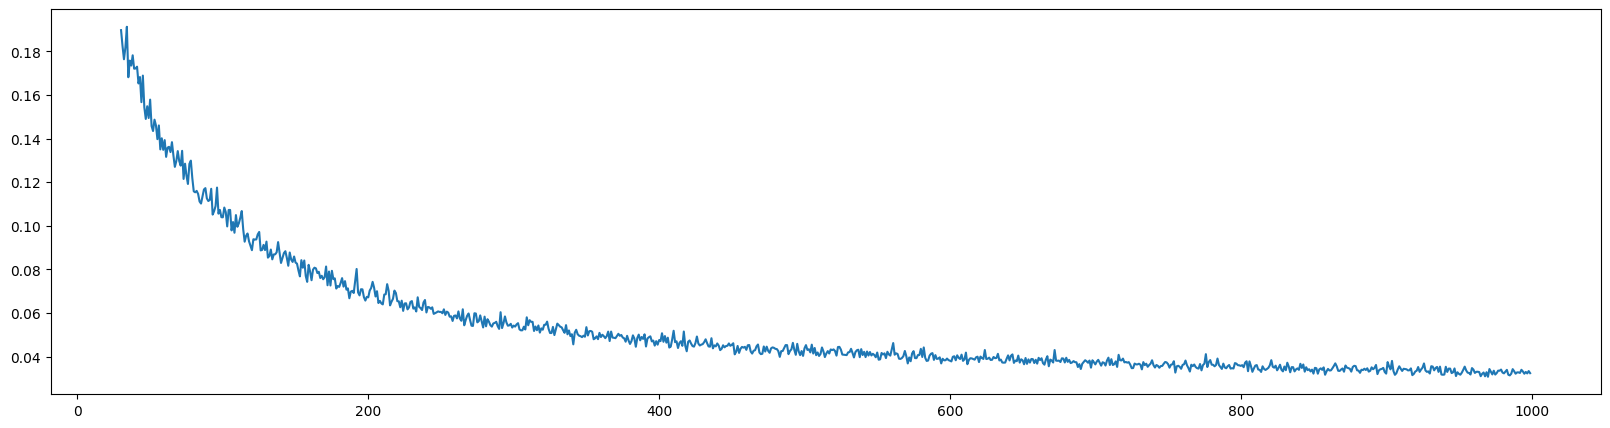

In [256]:
plt.figure(figsize=(20, 5))
plt.plot(loss_result.loc[30: , 'epochs'], loss_result.loc[30: , 'loss'])
plt.show()

### Test

In [257]:
test_result = pd.DataFrame(columns=['pred', 'pred_rescale', 'real'])
num = 0
min = scale_params.loc['min', 'kospi']
max = scale_params.loc['max', 'kospi']
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            pred_scaled = pred_ * (max - min) + min
            out_scaled = outputs.numpy()[i] * (max - min) + min
            test_result.loc[num] = [pred_, pred_scaled, out_scaled[0][0]]
            num += 1

In [258]:
test_result

,pred,pred_rescale,real
0,0.602376,2277.105842,2302.810059
1,0.639058,2371.951423,2310.550049
2,0.624063,2333.179182,2277.989990
3,0.574757,2205.693286,2301.560059
4,0.592940,2252.708057,2343.120117
...,...,...,...
134,0.753121,2666.875053,2683.649902
135,0.766467,2701.382009,2676.629883
136,0.761444,2688.395049,2676.629883
137,0.744360,2644.221387,2734.360107


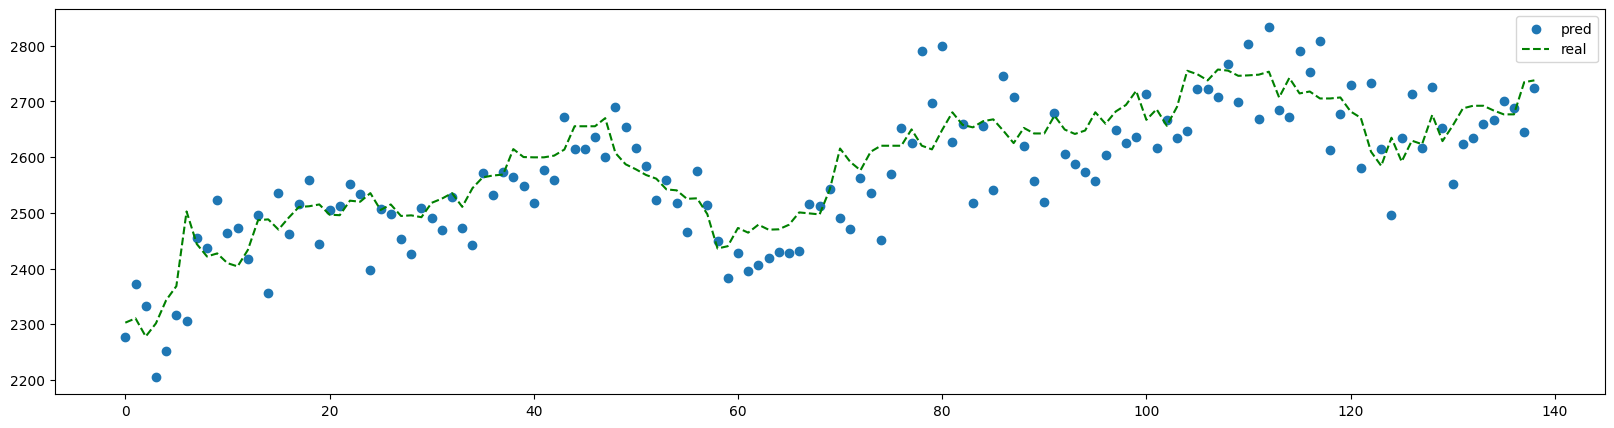

In [259]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

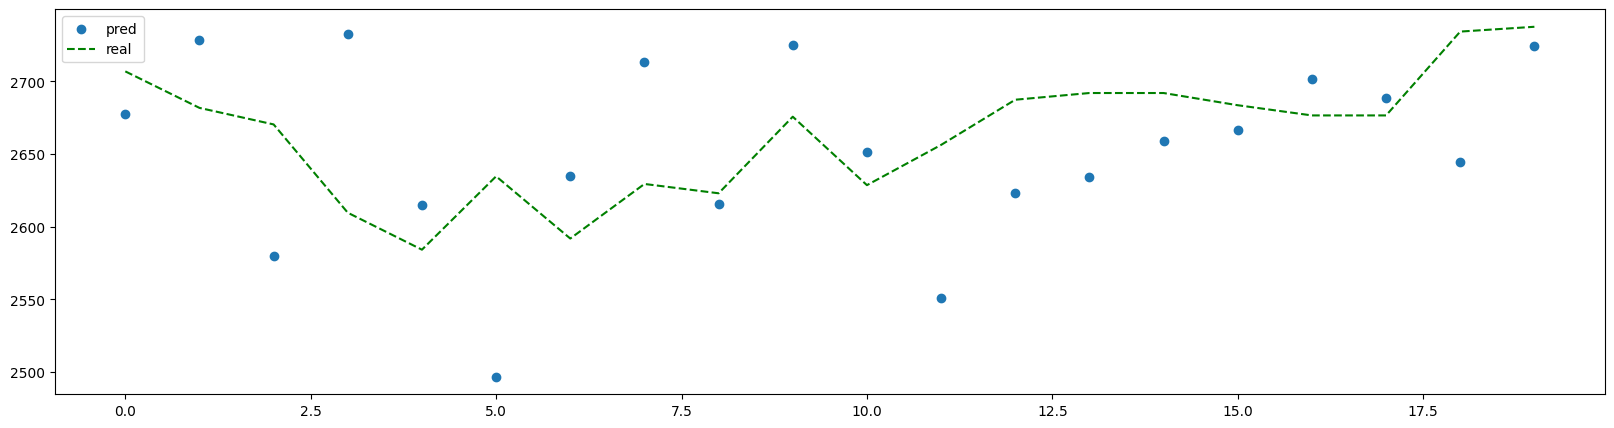

In [260]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 1], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

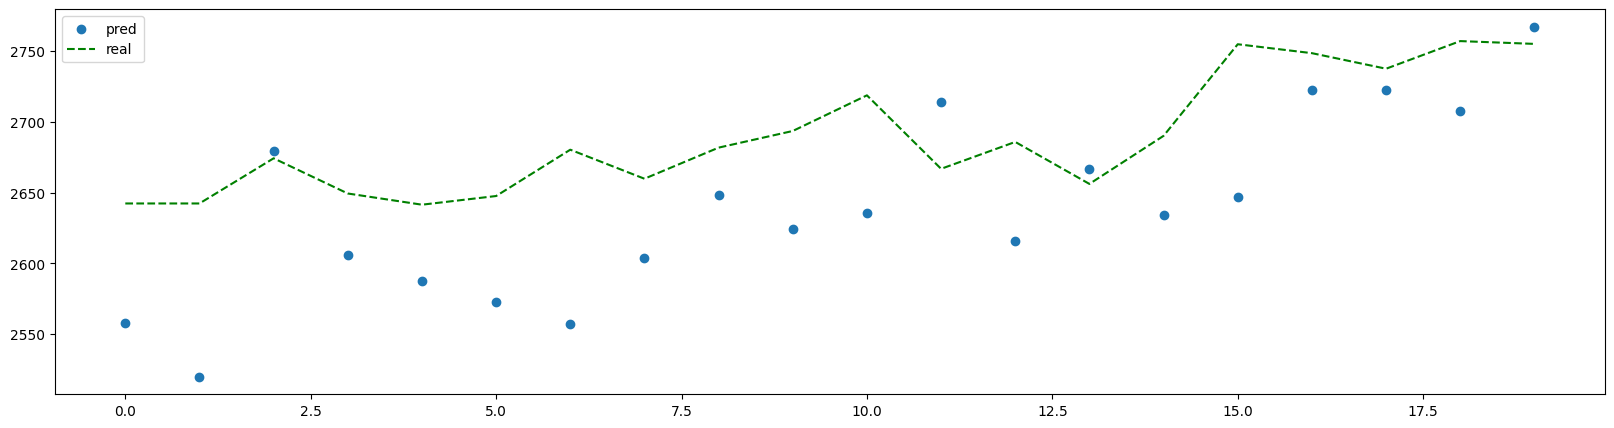

In [261]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 1], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

### moving average check - EMA(Exponential Moving Average)

In [269]:
df_ma = test_result.copy()
df_ma['sma_pred_5d'] = df_ma['pred_rescale'].rolling(5).mean()
df_ma['sma_pred_10d'] = df_ma['pred_rescale'].rolling(10).mean()
df_ma['sma_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['sma_real_5d'] = df_ma['real'].rolling(5).mean()
df_ma['sma_real_10d'] = df_ma['real'].rolling(10).mean()
df_ma['sma_real_20d'] = df_ma['real'].rolling(20).mean()
df_ma['ewm_pred_5d'] = df_ma['pred_rescale'].ewm(5).mean()
df_ma['ewm_pred_10d'] = df_ma['pred_rescale'].ewm(10).mean()
df_ma['ewm_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['ewm_real_5d'] = df_ma['real'].ewm(5).mean()
df_ma['ewm_real_10d'] = df_ma['real'].ewm(10).mean()
df_ma['ewm_real_20d'] = df_ma['real'].ewm(20).mean()
df_ma = df_ma.dropna()
df_ma

,pred,pred_rescale,real,sma_pred_5d,sma_pred_10d,sma_pred_20d,sma_real_5d,sma_real_10d,sma_real_20d,ewm_pred_5d,ewm_pred_10d,ewm_pred_20d,ewm_real_5d,ewm_real_10d,ewm_real_20d
19,0.666603,2443.172414,2514.959961,2503.245624,2472.218476,2429.928125,2499.625977,2471.964966,2420.952515,2467.438365,2446.198383,2429.928125,2476.336905,2454.753425,2439.329139
20,0.690465,2504.870642,2496.629883,2497.022153,2476.249938,2435.495005,2504.981934,2480.661963,2430.643506,2473.815700,2452.365605,2435.495005,2479.794218,2459.155189,2443.585553
21,0.693319,2512.250283,2495.659912,2507.181226,2480.219924,2441.048470,2505.873926,2489.851953,2439.898999,2480.339638,2458.572111,2441.048470,2482.487283,2462.938573,2447.353282
22,0.708793,2552.258834,2521.760010,2514.325996,2493.816192,2448.900644,2508.141943,2498.702954,2452.087500,2492.509880,2468.159824,2448.900644,2489.133055,2468.958242,2452.606881
23,0.701406,2533.160601,2519.810059,2509.142555,2497.449930,2454.716258,2509.763965,2502.016968,2463.000000,2499.371311,2474.736707,2454.716258,2494.311023,2474.103511,2457.245238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,0.753121,2666.875053,2683.649902,2626.823904,2647.516612,2653.816197,2682.308008,2656.023022,2664.506482,2647.000347,2655.520158,2653.816197,2669.036319,2670.831449,2669.217028
135,0.766467,2701.382009,2676.629883,2656.931371,2654.147161,2656.084214,2686.367969,2664.500000,2662.627478,2656.063957,2659.689427,2656.084214,2670.301913,2671.358581,2669.570485
136,0.761444,2688.395049,2676.629883,2669.982750,2651.647601,2657.624751,2684.205957,2669.218994,2660.576477,2661.452473,2662.299034,2657.624751,2671.356574,2671.837791,2669.907068
137,0.744360,2644.221387,2734.360107,2672.009794,2654.494752,2656.985735,2692.665967,2680.353003,2662.036487,2658.580625,2660.655609,2656.985735,2681.857163,2677.521649,2672.979920


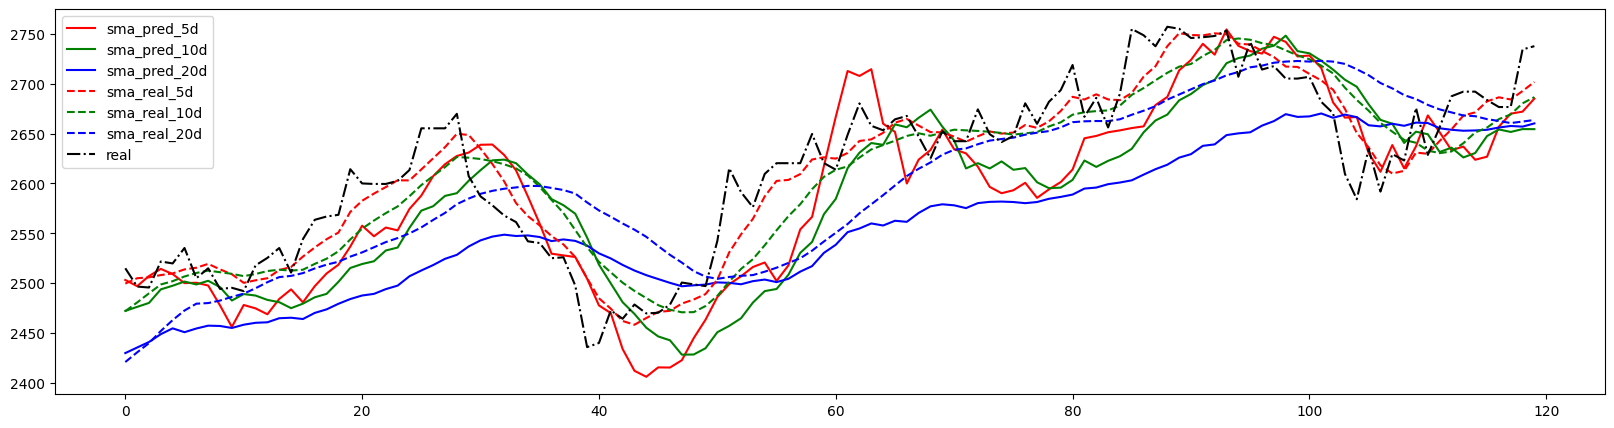

In [278]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

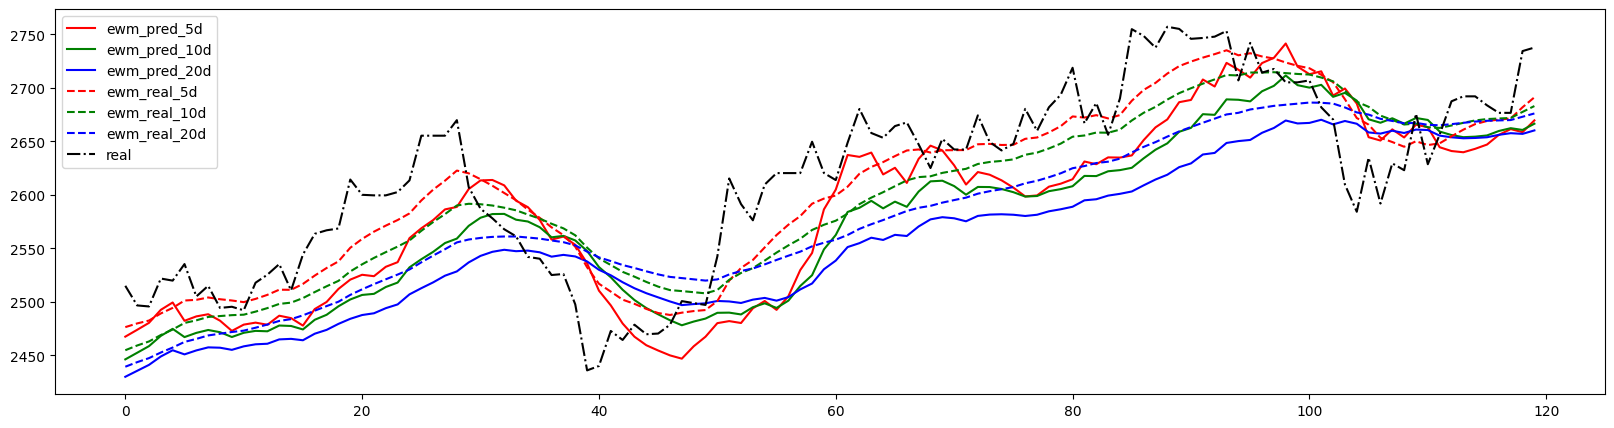

In [277]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['ewm_pred_5d'], 'r-', label='ewm_pred_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_10d'], 'g-', label='ewm_pred_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_20d'], 'b-', label='ewm_pred_20d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_5d'], 'r--', label='ewm_real_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_10d'], 'g--', label='ewm_real_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_20d'], 'b--', label='ewm_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()